In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../src'))
	print(os.getcwd())
except:
	pass


/home/rv-hdoosterlinck/repos/unlearning/src


In [3]:
import os
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.utils import to_categorical
from network import basenet, get_multitask_network, get_numberonly_network, \
    get_multitask_network_gradflip
from utils import colors as all_colors_rgb, color_MNIST, compile_model, evaluate_results

%load_ext autoreload
%autoreload 2

/home/rv-hdoosterlinck/.conda/envs/ludwig/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv-hdoosterlinck/.conda/envs/ludwig/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv-hdoosterlinck/.conda/envs/ludwig/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv-hdoosterlinck/.c

In [4]:
tf.__version__

'1.14.0'

In [5]:
import keras

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

import keras
keras.backend.tensorflow_backend.set_session(sess)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3282315830369412314
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10506925716430705180
physical_device_desc: "device: XLA_CPU device"
]
1.14.0


In [15]:
INITIAL_LR = 1e-4
EPOCHS = 30
PATIENCE = EPOCHS  # no early stopping here
BIAS = 0.9
GRADFLIP_LAMBDA = .1
DATA_FOLDER = '../data'
LOSS = 'categorical_crossentropy'
N = 200

# choose some colors
colors = {0: 'dark red',
          1: 'navy',
          2: 'gold',
          3: 'aqua',
          4: 'indigo',
          5: 'deep pink',
          6: 'chocolate',
          7: 'honeydew',
          8: 'dark violet',
          9: 'beige'
          }
colors_inv = {v: k for k, v in colors.items()}
colors_rgb = {k: all_colors_rgb[v] for k, v in colors.items()}
classes = list(colors.keys())

## Color-biased MNIST

In [16]:
# DATA
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# make two datasets with somewhat consistent color (aka BIAS)
x_train_color, y_train_color = color_MNIST(zip(x_train, y_train), colors, colors_rgb, bias=BIAS)
x_test_color_ref, y_test_color_ref = color_MNIST(zip(x_test, y_test), colors, colors_rgb, bias=BIAS)

# make a test dataset with fully scrambled color
x_test_color, y_test_color = color_MNIST(zip(x_test, y_test), colors, colors_rgb, bias=0)

y_train_color_onehot = to_categorical([colors_inv[c] for c in y_train_color])
y_train_multi = {'color': y_train_color_onehot, 'number': y_train_onehot}

# Ludwig

In [17]:
from ludwig.api import LudwigModel

### Write to disk

In [18]:
import cv2
M = 100

x_train_color_paths = []
for i, file in enumerate(x_train_color[:M]):
    p = f'/home/rv-hdoosterlinck/repos/unlearning/data/ludwig/train/{i}.jpg'
    cv2.imwrite(p, np.flip(file, -1))
    x_train_color_paths.append(p)

x_test_color_paths = []
for i, file in enumerate(x_test_color[:M]):
    p = f'/home/rv-hdoosterlinck/repos/unlearning/data/ludwig/test/{i}.jpg'
    cv2.imwrite(p, np.flip(file, -1))
    x_test_color_paths.append(p)
    

In [19]:
import pandas as pd
train_df = pd.DataFrame({
    'image': x_train_color_paths[:M],
    'number': y_train[:M],
    'color': y_train_color[:M]})

test_df = pd.DataFrame({
    'image': x_test_color_paths[:M],
    'number': y_test[:M],
    'color': y_test_color[:M]})

In [ ]:
## check that train df's number and color correlate more than test df's
# Counter(zip(train_df['number'], train_df['color']))
# Counter(zip(test_df['number'], test_df['color']))

### create simple model with no gradient reversal

In [ ]:
model = LudwigModel(model_definition_file='/home/rv-hdoosterlinck/repos/unlearning/testmodel.yaml')
train_stats = model.train(data_train_df=train_df, 
                          data_test_df=test_df)

In [ ]:
print(train_stats['train']['number']['accuracy'][-1]) # show train acc at last epoch
print(train_stats['test']['number']['accuracy'][-1]) # show test acc at last epoch

### introduce gradient reversal

In [ ]:
model_2 = LudwigModel(model_definition_file='/home/rv-hdoosterlinck/repos/unlearning/testmodel_gradweight.yaml')
train_stats_2 = model_2.train(data_train_df=train_df, 
                              data_test_df=test_df)

In [ ]:
print(train_stats_2['train']['number']['accuracy'][-1]) # show train acc at last epoch
print(train_stats_2['test']['number']['accuracy'][-1]) # show test acc at last epoch

In [ ]:
list(zip(train_stats_2['train']['color']['accuracy'],
         train_stats_2['test']['color']['accuracy']
        )
    )

# End Ludwig

In [20]:
# write away some results to jpg for inspection
shutil.rmtree(DATA_FOLDER)
for f in ['train', 'test']:
    [os.makedirs(os.path.join(DATA_FOLDER, f, str(label)), exist_ok=True)
     for label in classes]
    [os.makedirs(os.path.join(DATA_FOLDER, f, str(label)), exist_ok=True)
     for label in classes]

for i in range(N):
    path = os.path.join(DATA_FOLDER, 'train', str(y_train[i]), str(i)+'.jpg')
    ret = cv2.imwrite(path, x_train_color[i])
    assert ret

for i in range(N):
    path = os.path.join(DATA_FOLDER, 'test', str(y_test[i]), str(i)+'.jpg')
    ret = cv2.imwrite(path, x_test_color[i])
    assert ret


 ## train: number only, confirm bias

In [21]:
simplenet = basenet(input_shape=(28, 28, 3), n_conv=3,
                    init_filter_size=20, dropout_rate=0)
model_number = get_numberonly_network(backbone=simplenet)
model_number, callbacks = compile_model(model_number, 'mnist_number',
                                        loss=LOSS,  initial_lr=INITIAL_LR, patience=PATIENCE)
model_number.fit(x_train_color, y_train_onehot, validation_split=.2,
                 epochs=EPOCHS, callbacks=callbacks)



Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 11s 237us/step - loss: 0.8562 - acc: 0.7691 - val_loss: 0.5507 - val_acc: 0.8886
Epoch 2/30
48000/48000 [==============================] - 11s 234us/step - loss: 0.4609 - acc: 0.8994 - val_loss: 0.3743 - val_acc: 0.9160
Epoch 3/30
48000/48000 [==============================] - 11s 234us/step - loss: 0.3517 - acc: 0.9151 - val_loss: 0.3350 - val_acc: 0.9210
Epoch 4/30
48000/48000 [==============================] - 12s 249us/step - loss: 0.2977 - acc: 0.9237 - val_loss: 0.2679 - val_acc: 0.9318
Epoch 5/30
48000/48000 [==============================] - 11s 230us/step - loss: 0.2617 - acc: 0.9308 - val_loss: 0.2434 - val_acc: 0.9356
Epoch 6/30
48000/48000 [==============================] - 11s 230us/step - loss: 0.2363 - acc: 0.9360 - val_loss: 0.2247 - val_acc: 0.9389
Epoch 7/30
48000/48000 [==============================] - 11s 225us/step - loss: 0.2150 - acc: 0.9403 - val_loss: 0.

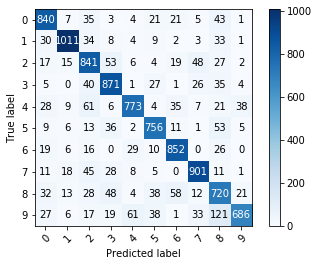

Accuracy: 82.51%
Per class statistics:
  - 0: precision 82.51%, recall 85.71%
  - 1: precision 92.67%, recall 89.07%
  - 2: precision 74.42%, recall 81.49%
  - 3: precision 81.25%, recall 86.24%
  - 4: precision 86.66%, recall 78.72%
  - 5: precision 82.89%, recall 84.75%
  - 6: precision 85.20%, recall 88.94%
  - 7: precision 86.97%, recall 87.65%
  - 8: precision 66.06%, recall 73.92%
  - 9: precision 90.38%, recall 67.99%


In [22]:
# Without bias
y_pred = np.argmax(model_number.predict(x_test_color), axis=1)
evaluate_results(y_test, y_pred, classes)


Compared to non-color data, training on colored data causes our model to become worse in predicting the number.


### train: Gradient Reversal
 In https://github.com/feidfoe/learning-not-to-learn/blob/master/trainer.py we see the authors train with a minimax game and gradient reversal.

 In essence, this means the head for color still tries to extract color info from the shared embedding, but during backprop we flip the gradient between the start of the color head and the embedding layer, meaning the shared weights move away from allowing encoding color information.

 Let's try the gradient reversal.

In [26]:
simplenet = basenet(input_shape=(28, 28, 3), n_conv=3,
                    init_filter_size=20, dropout_rate=0)

In [27]:
model_gradflip = get_multitask_network_gradflip(simplenet, gradflip_lambda=GRADFLIP_LAMBDA)

LOSS = 'categorical_crossentropy'
loss_weights = {
    "number": 1,
    "color": 1
}

model_gradflip, callbacks = compile_model(model_gradflip, 'mnist_number_color', LOSS,
                                          loss_weights=loss_weights, initial_lr=INITIAL_LR, patience=PATIENCE)
model_gradflip.fit(x_train_color, y_train_multi, validation_split=.2,
                   epochs=EPOCHS, callbacks=callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 12s 249us/step - loss: 5.3614 - number_loss: 1.1315 - color_loss: 4.2299 - number_acc: 0.7292 - color_acc: 0.2352 - val_loss: 2.5516 - val_number_loss: 0.5531 - val_color_loss: 1.9984 - val_number_acc: 0.8748 - val_color_acc: 0.2988
Epoch 2/30
48000/48000 [==============================] - 11s 238us/step - loss: 2.5860 - number_loss: 0.4869 - color_loss: 2.0991 - number_acc: 0.8862 - color_acc: 0.2558 - val_loss: 2.5559 - val_number_loss: 0.4103 - val_color_loss: 2.1456 - val_number_acc: 0.9016 - val_color_acc: 0.2333
Epoch 3/30
48000/48000 [==============================] - 11s 235us/step - loss: 2.4500 - number_loss: 0.3885 - color_loss: 2.0615 - number_acc: 0.9007 - color_acc: 0.2306 - val_loss: 2.2827 - val_number_loss: 0.3452 - val_color_loss: 1.9375 - val_number_acc: 0.9109 - val_color_acc: 0.2575
Epoch 4/30
48000/48000 [==============================] - 12s 249us/step - lo

Epoch 29/30
48000/48000 [==============================] - 12s 240us/step - loss: 1.8573 - number_loss: 0.1273 - color_loss: 1.7300 - number_acc: 0.9637 - color_acc: 0.3676 - val_loss: 1.8805 - val_number_loss: 0.1363 - val_color_loss: 1.7442 - val_number_acc: 0.9608 - val_color_acc: 0.3359
Epoch 30/30
48000/48000 [==============================] - 11s 235us/step - loss: 2.0019 - number_loss: 0.1328 - color_loss: 1.8690 - number_acc: 0.9620 - color_acc: 0.2969 - val_loss: 2.1238 - val_number_loss: 0.1453 - val_color_loss: 1.9784 - val_number_acc: 0.9574 - val_color_acc: 0.2660


In [28]:
model_gradflip.summary()

Model: "number_color_gradflip"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 26, 26, 20)   560         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 13, 13, 20)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 11, 11, 40)   7240        max_pooling2d_9[0][0]            
______________________________________________________________________________

 Now, lets predict on the inconsistently colored testset

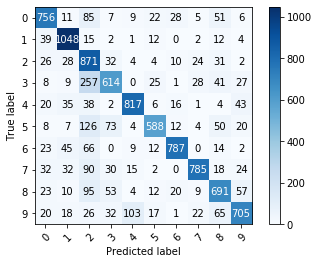

Accuracy: 76.62%
Per class statistics:
  - 0: precision 79.16%, recall 77.14%
  - 1: precision 84.31%, recall 92.33%
  - 2: precision 52.19%, recall 84.40%
  - 3: precision 72.66%, recall 60.79%
  - 4: precision 84.58%, recall 83.20%
  - 5: precision 84.00%, recall 65.92%
  - 6: precision 89.94%, recall 82.15%
  - 7: precision 89.20%, recall 76.36%
  - 8: precision 70.73%, recall 70.94%
  - 9: precision 79.21%, recall 69.87%


In [29]:
# no consistent coloring in the testset, contrary to the trainingset
# todo: how are we guaranteed of the order of outputs?
y_pred_number, y_pred_color = model_gradflip.predict(x_test_color)
y_pred_number = np.argmax(y_pred_number, axis=1)
evaluate_results(y_test, y_pred_number, classes)


## Conclusion

Following settings:  
INITIAL_LR = 1e-4  
EPOCHS = 50  
PATIENCE = EPOCHS  
BIAS = 0.9  
GRADFLIP_LAMBDA = .1  

Our testset accuracy in predicting the number went up from 84.33 to 90.4 percent, which is pretty decent. 

 # Notes:
 * Bias cannot be set to 1. If it is 1, color and number information align exactly and the two heads fight for keeping/destroying that information, without being able to nuance. Noisy bias ensures that there is indeed color info in the embedding, **separable** from number info.
 * Use a more powerful color branch (more dense layers) than the number branch so that simple hiding of color info in the embedding isn't enough.